In [1]:
# Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import pandas as pd
from sklearn.model_selection import train_test_split

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2023-05-21 16:11:34.713280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Get BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [3]:
# For testing
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

2023-05-21 16:12:30.032841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 16:12:30.073796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 16:12:30.074801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 16:12:30.077987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [4]:
# Test bert model
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626286   0.99280983 -0.1861189   0.36673835  0.15233701  0.65504444
  0.9681153  -0.948627    0.00216158 -0.9877732   0.06842719 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946322  0.3432122   0.33231512 ...  0.2130085   0.7102077
  -0.05771145]
 [-0.28742045  0.31981018 -0.2301861  ...  0.58455044 -0.21329743
   0.7269206 ]
 [-0.6615702   0.68876827 -0.8743304  ...  0.10877316 -0.26173204
   0.47855455]
 ...
 [-0.22561158 -0.28925583 -0.07064367 ...  0.47566044  0.83277196
   0.40025324]
 [-0.298242   -0.27473158 -0.05450519 ...  0.48849782  1.0955359
   0.1816341 ]
 [-0.44378144  0.00930715  0.07223722 ...  0.17290151  1.1833243
   0.07898054]]


In [6]:
# Build a model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [7]:
# Test model
classifier_model = build_classifier_model()
classifier_model.summary()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [14]:
# Load SMS data and prepare them for training

# Load the dataset
df = pd.read_csv('../dataset/set_01_02_new.csv', encoding='utf-8').dropna()
df.columns = ['label', 'text']

# Use sklearn to split the dataset into training, validating and testing
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=24)

# Create training dataset
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['label'].values)
)
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

# Create validation dataset
val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

# Create testing dataset
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)
test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

# Look at some data
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'SMS: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label}')


SMS: b'think u got think use got good ni number'
Label : 0
SMS: b'gain right wife dont demand trying husband let see'
Label : 0
SMS: b'someone u know asked dating service number contact cant guess call number revealed pobox number number xy number p'
Label : 1


2023-05-21 16:23:08.271959: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
# model fine tuning
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
print("steps_per_epoch ", steps_per_epoch)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-6
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

steps_per_epoch  114


In [22]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
114/114 [==============================] - 23s 164ms/step - loss: 0.0021 - binary_accuracy: 0.9992 - val_loss: 0.1457 - val_binary_accuracy: 0.9770
Epoch 2/5
114/114 [==============================] - 18s 159ms/step - loss: 3.4312e-04 - binary_accuracy: 1.0000 - val_loss: 0.1458 - val_binary_accuracy: 0.9760
Epoch 3/5
114/114 [==============================] - 18s 159ms/step - loss: 6.5408e-04 - binary_accuracy: 1.0000 - val_loss: 0.1362 - val_binary_accuracy: 0.9808
Epoch 4/5
114/114 [==============================] - 18s 158ms/step - loss: 3.2551e-04 - binary_accuracy: 1.0000 - val_loss: 0.1361 - val_binary_accuracy: 0.9818
Epoch 5/5
114/114 [==============================] - 18s 159ms/step - loss: 3.5059e-04 - binary_accuracy: 1.0000 - val_loss: 0.1335 - val_binary_accuracy: 0.9837


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


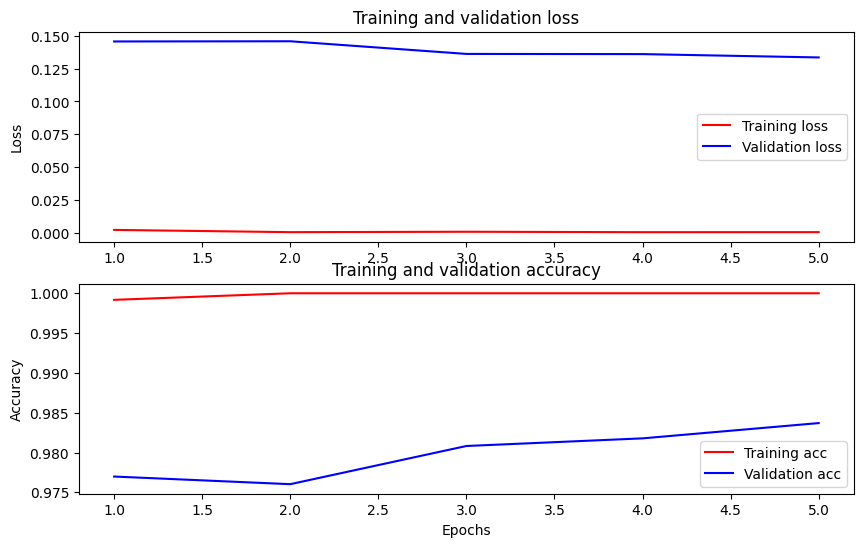

In [23]:

# Evaluate performance
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
    

In [25]:
# Save the model
classifier_model.save('saved_model/bertSmsClassifier')

In [24]:
# Evaluate testing dataset accuracy
loss, accuracy = classifier_model.evaluate(test_ds)
print('Testing set loss: ', loss)
print('Testing set accuracy: ', accuracy)

17/17 [==============================] - 1s 87ms/step - loss: 0.1253 - binary_accuracy: 0.9883
Testing set loss:  0.12530650198459625
Testing set accuracy:  0.9883494973182678
